# Utilisations des transformés de Fourier pour les bruits

Quand on parle de bruit on parle souvent aussi de **fréquences**. En effet un bruit même si il est purement aléatoire peut être considérée comme une **suite de fonctions à divers fréquences** qui peut aller jusqu'à une infinité de fonctions pour un bruit totalement aléatoire (mais **fini sur un domaine borné et dénombrable**).
    
Ainsi on peut en tirer deux questions : Que se passerait-il si on **filtrer les fréquences d'un bruit** de Perlin ? Ou encore pour un bruit **purement aléatoire** <=> Est-il possible de **produire un nouveau bruit** pseudo-aléatoire avec la transformé de Fourier ?

**Plan** :
1. **Filtres fréquentiels** pour le bruit de **Perlin** $\\[0 cm]$
    - Génération du bruit de **Perlin**
    - **Domaine fréquentiel** du bruit ($TF[]$)
    - **Filtre** et retour au domaine spatial ($TF^{-1}[]$) $\\[0 cm]$
2. Génération d'un **nouveau bruit pseudo-aléatoire** $\\[0 cm]$
    - Génération du bruit **Random**
    - Domaine fréquentiel du bruit
    - Filtre et retour au domaine spatial

## Filtres fréquentiels

On souhaite avoir qu'un échantillon des fréquences d'un bruit de Perlin "complet" afin de vérifier ce que nous avons dit plus haut et voir si on peut avoir un bruit de Perlin à faible fréquence si on utilise un filtre passe-bas sur le domaine fréquentiel.

### Génération du bruit de Perlin

On commence donc par générer notre bruit de Perlin, via le module que nous avons développé précedemment, en lui mettant une très forte fréquence spatiale ainsi qu'une bonne résolution.

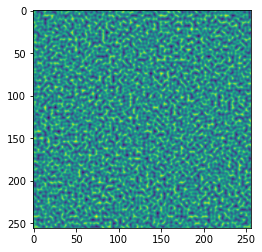

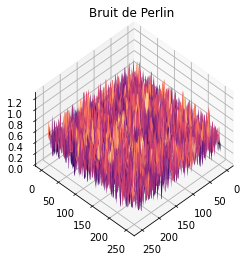

In [488]:
import numpy as np
import perlin2D as perlin
import matplotlib.pyplot as plt

#La TF est calculée plus vite si on est en puissance de 2(car méthode qu'utilise numpy)
shape = 2**8
noise = perlin.Perlin2D([shape,shape],[2**6,2**6]).noise

#On génère une grille/système de coo pour pyplot
X, Y = np.mgrid[0:shape, 0:shape]

#On rend le bruit en 2D
fig = plt.figure(figsize = (4,4))
ax = plt.axes()
ax.imshow(noise)
plt.show()

#On rend le bruit en 3D
fig = plt.figure(figsize = (4,4))
ax = plt.axes(projection ='3d')
ax.set_proj_type('ortho')
ax.view_init(45, 45)
ax.set_zlim3d(0,1.3)
plt.title('Bruit de Perlin')
ax.plot_surface(X, Y, noise, cmap="magma",linewidth=0, antialiased=True)

### Domaine fréquentiel du bruit ( 𝑇𝐹[] )

Appliquons la transformé de Fourier pour ce bruit, nous utiliserons une unité arbitraire pour la fréquence qui est de 1 à {shape} (ici 512). Les basses fréquences sont celles proches de 0.


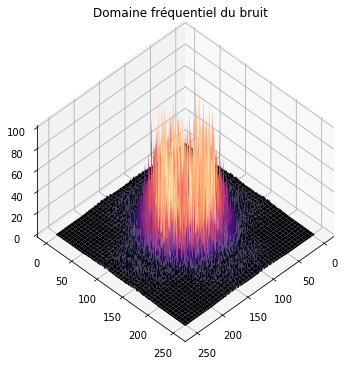

In [469]:
#On applique la tf 2D à l'aide de numpy
fft = np.fft.fft2(noise)

#On centre la TF, seulement pour le côté visuel d'où une variable à côté.
dfft = np.fft.fftshift(fft/2)

#paramètres du rendu
fig = plt.figure(figsize = (4,4))
ax = plt.axes(projection ='3d')
ax.set_proj_type('ortho')
ax.view_init(45, 45)
ax.set_zlim3d(0,100)
plt.title("Domaine fréquentiel du bruit")

#coordonnées
x, y = np.mgrid[:shape,:shape]

#On rend les valeurs absolues des valeurs de la matrice du bruit car ça permet d'avoir une belle répartition de couleur. 
ax.plot_surface(x, y, np.abs(dfft[:len(x),:len(y)]), cmap="magma",linewidth=0, antialiased=True)

On observe bien que le nombre de fréquences est élevé vu la complexité apparente de la fonction 2D. 

### Filtre et retour au domaine spatial ( 𝑇𝐹−1[] )

On programme une simple fonction de filtre qui si la fréquence est trop haute ou basse on réduit le bruit à 0.
Puis on applique la transformée de Fourier inverse.



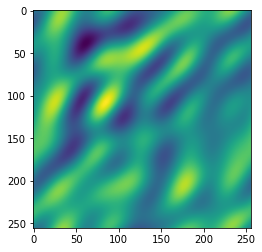

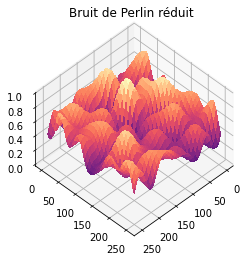

In [487]:

#Bornes du filtre
limit_f = [0,5]
fX = X
fY = Y

#On vérifie si on est bien dans les bornes, sinon on réduit le bruit à 0
l_fft = np.copy(fft[:len(fX),:len(fY)])
for i in range(len(fX)):
    for j in range(len(fY)):
        if(fX[i][0] > limit_f[1] or fY[0][j] > limit_f[1] or fX[i][0] < limit_f[0] or fY[0][j] < limit_f[0]):
            l_fft[i][j] = 0

#On retourne dans le domaine spatiale avec la TF inverse
ifft = np.fft.ifft2(l_fft)
#On prend les valeurs réels, celles qui ont un réel sens physique.
low_noise = np.real(ifft)

#Rendu 2D du bruit
fig = plt.figure(figsize = (4,4))
ax = plt.axes()
ax.imshow(low_noise)
plt.show()
  
#rendu et normalisation du bruit pour la 3D
X, Y = np.mgrid[0:len(low_noise), 0:len(low_noise)]
low_noise = low_noise - low_noise.min()
low_noise = low_noise / low_noise.max()
fig = plt.figure(figsize = (4,4))
ax = plt.axes(projection ='3d')
ax.set_proj_type('ortho')
ax.view_init(45, 45)
plt.title('Bruit de Perlin réduit')
ax.plot_surface(X, Y, low_noise, cmap="magma",linewidth=0, antialiased=False)
        

## Génération d'un nouveau bruit pseudo-aléatoire

Si on observe un bruit purement aléatoire et un bruit de Perlin à haute fréquence spatiale initiale on voit une forte ressemblance et on ne voit pas la différence si la fréquence est assez haute avec une résolution faible, en effet quand la fréquence augmente les "bulles" du bruit de Perlin vont diminuer en taille et finir par former des points comme pour un bruit Random.

![](img/bruitperlinrandom.png)

Il serait donc intéressant d'essayer d'appliquer un filtre passe-bas pour un bruit random et voir ce que ça donne.

### Génération du bruit Random

Commençons par générer un bruit totalement(hypothétiquement) aléatoire.

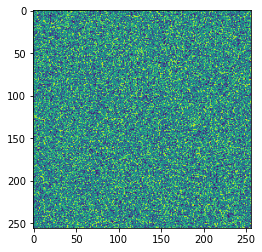

In [1]:
import numpy as np
import matplotlib.pyplot as plt

shape = 2**8
#On génère le bruit aléatoire
noise = np.random.rand(shape, shape)
#Rendu
fig = plt.figure(figsize = (4,4))
ax = plt.axes()
ax.imshow(noise)
plt.show()

### Domaine fréquentiel du bruit
Même étape que précedemment: On applique une première TF au bruit random.

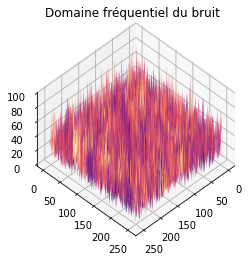

In [2]:
#On applique la tf 2D à l'aide de numpy
fft = np.fft.fft2(noise)

#On centre la TF, seulement pour le côté visuel d'où une variable à côté.
dfft = np.fft.fftshift(fft/2)

#paramètres du rendu
fig = plt.figure(figsize = (4,4))
ax = plt.axes(projection ='3d')
ax.set_proj_type('ortho')
ax.view_init(45, 45)
ax.set_zlim3d(0,100)
plt.title("Domaine fréquentiel du bruit")

#coordonnées
x, y = np.mgrid[:shape,:shape]

#On rend les valeurs absolues des valeurs de la matrice du bruit car ça permet d'avoir une belle répartition de couleur. 
ax.plot_surface(x, y, np.abs(dfft[:len(x),:len(y)]), cmap="magma",linewidth=0, antialiased=True)

On observe que ça a l'air tout autant aléatoire que le bruit d'origine. Mais que se passe t-il si on applique un filtre passe-bas ? Le bruit sera t-il cohérent dans l'espace ?

### Filtre et retour au domaine spatial

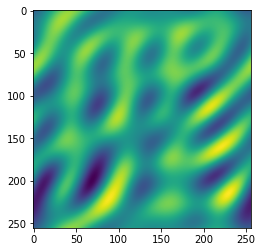

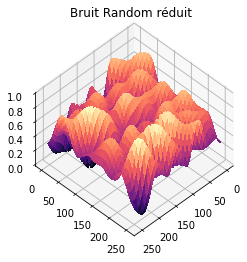

In [4]:

#Bornes du filtre
limit_f = [0,5]
fX, fY = np.mgrid[0:shape, 0:shape]

#On vérifie si on est bien dans les bornes, sinon on réduit le bruit à 0
l_fft = np.copy(fft[:len(fX),:len(fY)])
for i in range(len(fX)):
    for j in range(len(fY)):
        if(fX[i][0] > limit_f[1] or fY[0][j] > limit_f[1] or fX[i][0] < limit_f[0] or fY[0][j] < limit_f[0]):
            l_fft[i][j] = 0

#On retourne dans le domaine spatiale avec la TF inverse
ifft = np.fft.ifft2(l_fft)
#On prend les valeurs réels, celles qui ont un réel sens physique.
low_noise = np.real(ifft)

#Rendu 2D du bruit
fig = plt.figure(figsize = (4,4))
ax = plt.axes()
ax.imshow(low_noise)
plt.show()
  
#rendu et normalisation du bruit pour la 3D
X, Y = np.mgrid[0:len(low_noise), 0:len(low_noise)]
low_noise = low_noise - low_noise.min()
low_noise = low_noise / low_noise.max()
fig = plt.figure(figsize = (4,4))
ax = plt.axes(projection ='3d')
ax.set_proj_type('ortho')
ax.view_init(45, 45)
plt.title('Bruit Random réduit')
ax.plot_surface(X, Y, low_noise, cmap="magma",linewidth=0, antialiased=False)

On finit par observer un bruit très similaire au bruit de Perlin, tellement qu'on ne voit pas la différence. Nous avons donc généré une alternative au bruit de Fourier. Pourquoi n'est-elle pas plus utilisée ? Car faire 2 transformées de Fourier demande bien plus d'opérations que celles utilisés pour le bruit de Perlin ou le bruit Simplex(version améliorée du bruit de Perlin(dev aussi par Ken Perlin)).

![](img/benchmark.png)

On observe qu'en effet plus notre taille est grande plus la méthode avec la TF va être cher en performance. Néanmoins pour des petites résolutions le temps de rendu est similaire, par exemple pour notre cas: 512 = $2^8$. Néanmoins pour une r&elle utilisation les résolutions sont bien plus grande, d'où le grand besoin d'optimisations pour avoir du temps réel nécessaire dans les jeux vidéos par exemple.